In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
#%%
from ntm import NTM
from dataloader import associative_dataloader
from torch import nn, optim
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
#%%

In [3]:
item_width=6
item_length = 3
item_min_count = 2
item_max_count = 6

input_size=item_width+2
output_size= item_width
controller_size=100
memory_units=128
memory_unit_size=20
batch_size=1
num_heads=1
total_iteration =100000
num_batches = total_iteration//batch_size 



In [4]:
device = torch.device("cpu")
data = associative_dataloader(num_batches=num_batches,
                              batch_size=batch_size,
                              item_width = item_width,
                              item_length=item_length,
                              max_item_count= item_max_count,
                              min_item_count=item_min_count,
                              device = device
                             )

ntm = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)

criterion = nn.BCELoss()
optimizer = optim.RMSprop(ntm.parameters(),
                          lr=1e-4,
                          alpha=0.95,
                          momentum=0.9)

In [ ]:
#%%
print("Starting training")
print_every = 500
losses =[]
errors =[]
best_error = 1e6
for batch, (x,y) in(enumerate(data)):
    optimizer.zero_grad()
    ntm.reset(batch_size)
    
#     print("Sendning inputs")
    for i in range(x.size(0)):
        input_vector = x[i]
        ntm(input_vector)

    outputs = torch.zeros(y.size()).to(device)

    zero_input = torch.zeros([batch_size,input_size]).to(device)
#     print("Finding Outputs")
    for i in range(y.size(0)):
        outputs[i],_ = ntm(zero_input)
    
#     print("Backprop step")
#     print(f"Outputs {outputs}")
#     print(f"y {y}")
    loss = criterion(outputs, y)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_value_(ntm.parameters(), 10)
    optimizer.step()
    
    out_binarized = outputs.clone().data
    out_binarized = out_binarized.cpu().detach().apply_(lambda x: 0 if x < 0.5 else 1).to(device)
    
    # The cost is the number of error bits per sequence
    cost = torch.sum(torch.abs(out_binarized - y.data))
    errors.append(cost.item()/batch_size)
    best_error = min(best_error,losses[-1])
    if (batch%print_every ==0 or best_error == losses[-1]):
        print(f"Finished batch: {batch}, loss:{losses[-1]:.3e}, cost: {errors[-1]}")
        torch.save(ntm.state_dict(), f'checkpoints/associative/v2-{batch}_error_{losses[-1]:.3e}_cost_{int(errors[-1])}.pt')


Starting training
Finished batch: 0, loss:6.587e-01, cost: 7.0
Finished batch: 6, loss:6.472e-01, cost: 6.0
Finished batch: 8, loss:6.251e-01, cost: 3.0
Finished batch: 14, loss:6.171e-01, cost: 4.0
Finished batch: 15, loss:5.255e-01, cost: 0.0
Finished batch: 18, loss:4.671e-01, cost: 0.0
Finished batch: 27, loss:4.479e-01, cost: 0.0
Finished batch: 30, loss:4.475e-01, cost: 0.0
Finished batch: 91, loss:4.362e-01, cost: 0.0
Finished batch: 92, loss:4.286e-01, cost: 0.0
Finished batch: 98, loss:3.910e-01, cost: 0.0
Finished batch: 386, loss:3.845e-01, cost: 0.0
Finished batch: 391, loss:3.524e-01, cost: 0.0
Finished batch: 393, loss:3.522e-01, cost: 0.0
Finished batch: 500, loss:8.383e-01, cost: 11.0
Finished batch: 593, loss:3.423e-01, cost: 0.0
Finished batch: 598, loss:3.190e-01, cost: 0.0
Finished batch: 608, loss:2.896e-01, cost: 0.0
Finished batch: 611, loss:2.888e-01, cost: 0.0
Finished batch: 617, loss:2.882e-01, cost: 0.0
Finished batch: 624, loss:2.699e-01, cost: 0.0
Finished

In [6]:
mpl.rcParams['figure.dpi']=100
plt.rcParams['image.cmap'] = 'binary_r'
plt.rcParams['image.cmap'] = 'Blues_r'

In [7]:
import numpy as np
def print_head(h):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,10))
    fig
    h = np.array(h)
    r = h[:,0,:,:]
    w = h[:,1,:,:]
   # ax1.figure(figsize=(10,20))
    ax1.imshow(r.T.squeeze())
    ax1.set_title("Read Head locations")
#     plt.show()
#     plt.figure(figsize=(10,20))
    ax2.imshow(w.T.squeeze())
    ax2.set_title("Write Head locations")
    plt.show()

## Input and Target

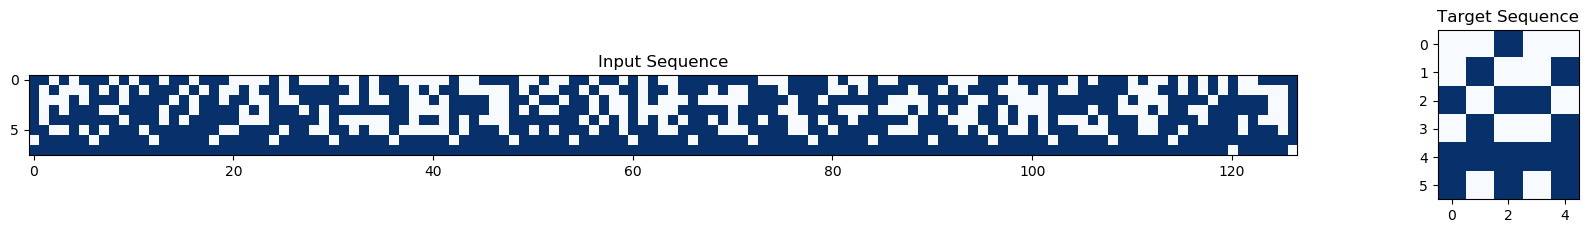

In [154]:
test = associative_dataloader(1,1,6,5,20,20,device)
x,y = next(test)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20),gridspec_kw={'width_ratios': [9, 1]})
ax1.imshow(x.squeeze().t())
ax1.set_title("Input Sequence")
ax2.imshow(y.squeeze().t())
ax2.set_title("Target Sequence")
plt.show()

In [155]:
ntm_pretrained = NTM(input_size,output_size,controller_size,memory_units,memory_unit_size,num_heads,device)
ntm_pretrained.load_state_dict(torch.load("checkpoints/associative/v2-final.pt"))
model = ntm_pretrained
# model = ntm
model.reset(batch_size=1)
with torch.no_grad():
    h1 =[]
    for i in range(x.size(0)):
            input = x[i]
            _,head = model(input)
            h1.append(head)
    outputs = torch.zeros(y.size())
    
    zero_input = torch.zeros([1,input_size])
    #     print("Finding Outputs")
    h2 =[]
    for i in range(y.size(0)):
        outputs[i],head = model(zero_input)
        h2.append(head)
    head_weights = np.concatenate((np.array(h1),np.array(h2)),axis=0)




## Output from network 

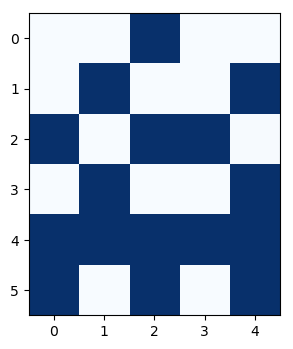

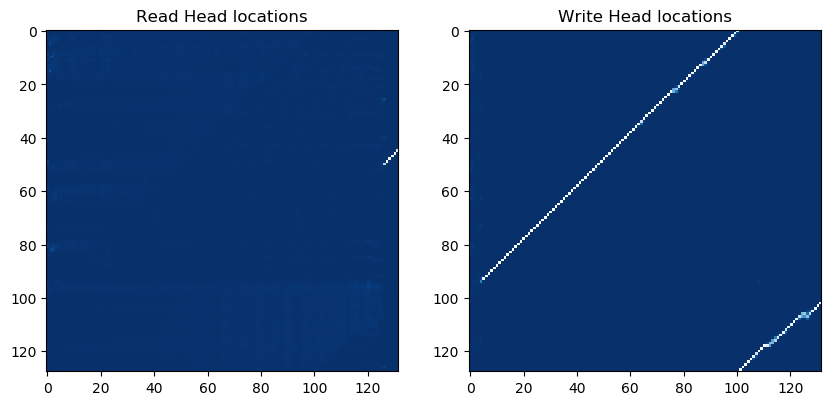

In [156]:
plt.figure(figsize=(4,4))
plt.imshow(outputs.squeeze().t())
print_head(head_weights)

## Error between target and output

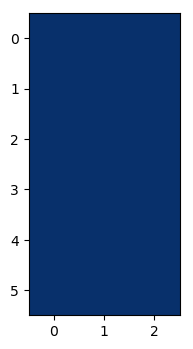

In [32]:
plt.imshow((y-outputs).round().squeeze().t())
plt.show()